In [1]:
import sys
sys.path.append('/home2/ebrahim/beyond-brainscore/analyze_results/figures_code/')
from trained_untrained_results_funcs import find_best_layer,load_mean_sem_perf, loop_through_datasets
import numpy as np
from matplotlib import pyplot as plt


In [2]:
exp = ['243', '384']

br_labels_dict = {}
num_vox_dict = {}
subjects_dict = {}

data_processed_folder_pereira = f'/data/LLMs/data_processed/pereira/dataset'
data_processed_folder_fed = f'/data/LLMs/data_processed/fedorenko/dataset'
data_processed_folder_blank = f'/data/LLMs/data_processed/blank/dataset'

subjects_storage = {}
network_labels_storage = {}
lang_indices = {}

for e in exp:

    bre = np.load(f'{data_processed_folder_pereira}/networks_{e}.npy', allow_pickle=True)
    network_labels_storage[f"pereira{e}"]  = bre.squeeze()
    num_vox_dict[e] = bre.shape[0]
    subjects_storage[f"pereira{e}"] = np.load(f"{data_processed_folder_pereira}/subjects_{e}.npy", allow_pickle=True).squeeze()
    lang_indices[e] = np.argwhere(bre=='language').squeeze()

subjects_storage['fedorenko']  = np.load(f"{data_processed_folder_fed}/subjects.npy", allow_pickle=True)
subjects_storage['blank'] = np.load(f"{data_processed_folder_blank}/subjects.npy", allow_pickle=True)

network_labels_storage['fedorenko'] = None
network_labels_storage['blank'] = None

subjects_arr_pereira = np.load(f"{data_processed_folder_pereira}/subjects_complete.npy", allow_pickle=True)
networks_arr_pereira = np.load(f"{data_processed_folder_pereira}/network_complete.npy", allow_pickle=True)

resultsPath_base = '/data/LLMs/brainscore/'
                    

### For GPT2 and OASM, the best layer is found in the figure1.py file and saved into a dictionary for future use
### For the Pereira2018 PWR model, there is no selection of layers.

In [17]:
for d, fe, exp, subjects, network in loop_through_datasets(['pereira', 'fedorenko', 'blank'], ['']):

  
    if d == 'pereira':
        lang_indices = np.argwhere(network=='language').squeeze()
    else:
        lang_indices = None
        
    e = exp.strip('_')
    layer_perf_dict_blank_glove_sp, _, _  = find_best_layer([0], '', exp=exp, resultsPath=f'/data/LLMs/brainscore/results_{d}/', 
                                                                        subjects=subjects_storage[f'{d}{e}'], dataset=d, perf='out_of_sample_r2', 
                        selected_network_indices = lang_indices, feature_extraction = '', model_name='glove-sp', seed_number=None, 
                        return_SE=False, niter=1)

    layer_perf_dict_blank_glove_mp, _, _ = find_best_layer([0], '', exp=exp, resultsPath=f'/data/LLMs/brainscore/results_{d}/', 
                                                                        subjects=subjects_storage[f'{d}{e}'], dataset=f'{d}', perf='out_of_sample_r2', 
                        selected_network_indices = lang_indices, feature_extraction = '', model_name='glove-mp', seed_number=None, 
                        return_SE=False, niter=1)

    print(d, exp)
    print(layer_perf_dict_blank_glove_sp[0], layer_perf_dict_blank_glove_mp[0])

pereira _243
0.016240908388800095 0.0028673114162520307
pereira _384
0.010924025079621973 0.01246861708365666
fedorenko 
0.02748019368014525 0.026349217245011974
blank 
-0.0010923773725976748 -0.0010197856989986116


In [6]:
layer_perf_dict, best_layer_blank, layer_perf_best  = find_best_layer(np.arange(3,51), '', '', resultsPath='/data/LLMs/brainscore/results_blank/', subjects=subjects_storage['blank'], dataset='blank', perf='pearson_r', 
                    selected_network_indices = None, feature_extraction = '', model_name='pos-WN', seed_number=None, 
                    return_SE=False, niter=1)

print("Best layer Blank simple feature space: ", best_layer_blank)

Best layer Blank simple feature space:  12


Best layer Fed feature space:  4.7


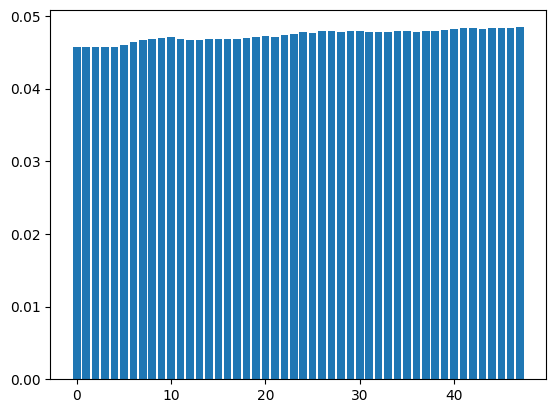

In [52]:
# Due to an indexing error, layer 4.6 was accidently used for Fed, but as is evident from the bar plot 
# the difference in performance is very small so computations were not rerun with layer 4.7
layer_perf_pos_fed = []
for i in np.round(np.arange(0, 4.8, 0.1),2):
    perf_mean = load_mean_sem_perf('pos', 'fedorenko', '', i, niter=1, return_mean=True, print_res=False)
    layer_perf_pos_fed.append(perf_mean)

plt.bar(np.arange(len(layer_perf_pos_fed)), layer_perf_pos_fed)
print("Best layer Fed feature space: ", np.round(np.arange(0, 4.8, 0.1),2)[np.argmax(layer_perf_pos_fed)])

In [9]:
import pandas as pd


def load_perf(filepath, perf, clip_zero=False, return_SE=False, shape_pereira_full=None, non_nan_indices_dict=None, exp='', dataset=None):
    
    perf_arr = np.nan_to_num(np.load(filepath)[perf])
    
    if clip_zero:
        return np.clip(perf_arr, 0, np.inf)
    
    if return_SE:
        
        se = compute_squared_error(np.load(filepath)['y_hat'], dataset, exp)
        
        if len(exp)>0:
            
            exp = exp.strip('_')
            
            se_full = np.full(shape_pereira_full, fill_value=np.nan)
            
            if '243' in exp:
                se_full[:243, non_nan_indices_dict[exp]] = se
                
            else:
                se_full[243:, non_nan_indices_dict[exp]] = se
                
            return perf_arr, se_full
                
        else:
            
            return perf_arr, se
    
    return perf_arr
    
def load_mean_sem_perf(model_name, dataset, feature_extraction, layer_num, 
                       resultsPath='/data/LLMs/brainscore/', seed_str='', noL2_str='', niter=1, perf='out_of_sample_r2', median=False, 
                       var_par_naming=False, return_perf=False, return_mean=False, print_res=True, clip_res=True, shuffled=False):

   if dataset == 'pereira':
      subjects_perf_pd = {'perf': [], 'subjects': [], 'Exp': []}
   else:
      subjects_perf_pd = {'perf': [], 'subjects': []}
      
   if shuffled: 
       shuffled_str = 'shuffled/'
   else:
       shuffled_str = ''

   for d, fe, exp, subjects, network in loop_through_datasets([dataset], [feature_extraction]):

      lang_indices = np.argwhere(network=='language')

      if var_par_naming:
         model_name_replaced= model_name.replace('EXP', exp)
         layer_perf = load_perf(f'{resultsPath}/results_{dataset}/{shuffled_str}{dataset}_{model_name_replaced}{feature_extraction}{seed_str}_{niter}{noL2_str}{exp}.npz', perf, clip_zero=clip_res)
      else:
         layer_perf = load_perf(f'{resultsPath}/results_{dataset}/{shuffled_str}{dataset}_{model_name}{feature_extraction}{seed_str}_{layer_num}_{niter}{noL2_str}{exp}.npz', perf, clip_zero=clip_res)

      subjects_perf_pd['perf'].extend(layer_perf[lang_indices].squeeze())
      subjects_perf_pd['subjects'].extend(subjects[lang_indices].squeeze())

      if len(exp) > 0:
         subjects_perf_pd['Exp'].extend(np.repeat(exp, len(lang_indices)))

   subjects_perf_pd = pd.DataFrame(subjects_perf_pd)
      
   if median:
      if dataset == 'pereira':
            subject_avg_pd = subjects_perf_pd.groupby(['subjects', 'Exp']).median()
            subject_avg_pd = subject_avg_pd.groupby(['subjects']).mean() # mean across experiments 
      else:
            subject_avg_pd = subjects_perf_pd.groupby(['subjects']).median()
      
   else:
      if dataset == 'pereira':
            subject_avg_pd = subjects_perf_pd.groupby(['subjects', 'Exp']).mean()
            subject_avg_pd = subject_avg_pd.groupby(['subjects']).mean() # mean across experiments 
      else:
            subject_avg_pd = subjects_perf_pd.groupby(['subjects']).mean()
            
   
   if print_res:
      print(model_name, f"{float(subject_avg_pd.mean().iloc[0]):.2g}", f"{float(subject_avg_pd.std().iloc[0] / np.sqrt(len(subject_avg_pd))):.2g}")

   if return_perf:
      if dataset == 'pereira':
         subjects_perf_384 = subjects_perf_pd.loc[subjects_perf_pd['Exp']=='_384']['perf']
         subjects_perf_243 = subjects_perf_pd.loc[subjects_perf_pd['Exp']=='_243']['perf']
         return subjects_perf_384, subjects_perf_243
      else:
         return subjects_perf_pd['perf']
   
   if return_mean:
      return float(subject_avg_pd.mean().iloc[0])


Best layer Fed feature space:  0.1


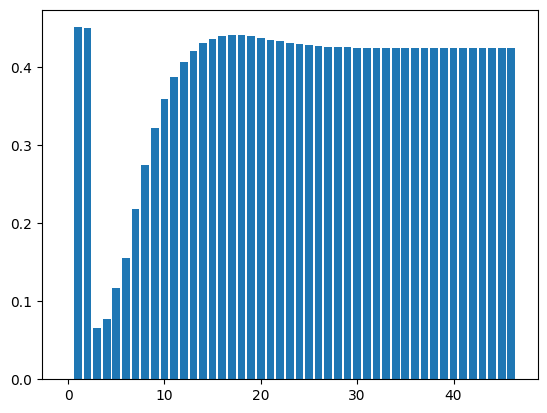

In [16]:
layer_perf_pos_fed = []
for i in np.round(np.arange(0.1, 4.8, 0.1),2):
    perf_mean = load_mean_sem_perf('OASM-all-sigma', 'pereira', '', i, niter=1, return_mean=True, print_res=False, shuffled=True, perf='pearson_r', clip_res=False)
    layer_perf_pos_fed.append(perf_mean)

plt.bar(np.arange(len(layer_perf_pos_fed)), layer_perf_pos_fed)
print("Best layer Fed feature space: ", np.round(np.arange(0, 4.8, 0.1),2)[np.argmax(layer_perf_pos_fed)])

In [ ]:
 pereira_OASM-all-sigma_0.1_1_243.npz